# Explainable AI con algoritmi genetici

In questo notebook si prova ad analizzare un possibile approccio genetico a
problemi di explainable AI, prendendo un modello **Random Forest** come black
box di riferimento.

Di seguito cerco di proporre una metodologia applicabile a problemi di ogni
ordine di grandezza ma per semplicità tratterò un semplice problema di
classificazione in cui ogni punto è composto da due sole feature e le possibili
classi per ogni punto sono soltanto due.


In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification


X, y = make_classification(
    n_samples=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=1,
    shuffle=True,
    random_state=0,
)

df = pd.DataFrame({"feature1": X.T[0], "feature2": X.T[1], "class": y})
df

,feature1,feature2,class
0,1.070334,-0.929154,1
1,-0.475656,1.278883,0
2,0.885906,1.690195,1
3,1.365818,1.077153,1
4,-1.260713,0.895089,0
...,...,...,...
195,0.858270,2.063549,1
196,0.628935,2.615793,1
197,0.359017,-1.073006,1
198,-0.521872,0.578906,0


Proseguiamo con il dividere il dataset in training set e test set. Di seguito
un plot del training set.


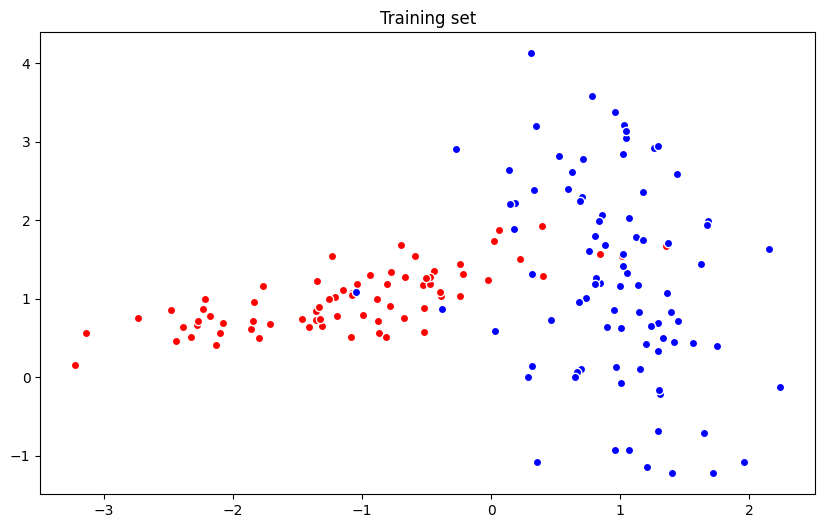

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

cls0 = [i for i in range(len(y_train)) if y_train[i] == 0]
cls1 = [i for i in range(len(y_train)) if y_train[i] == 1]

cmap = plt.get_cmap("Set1")
plt.figure(figsize=(10, 6))
plt.title("Training set")
plt.scatter(X_train.T[0][cls0], X_train.T[1][cls0], c="r", ec="w")
plt.scatter(X_train.T[0][cls1], X_train.T[1][cls1], c="b", ec="w")
plt.show()

Abbiamo quindi un training set e un test set su cui allenare e testare il
modello rispettivamente. Più precisamente non sfrutteremo la parte di test set
che ci fornisce la classe giusta per i punti classificati. Non è di nostro
interesse infatti testare la correttezza del modello.

Proseguiamo quindi con il training e la classificazione dei nuovi punti i quali
diventeranno centrali nella nostra analisi.


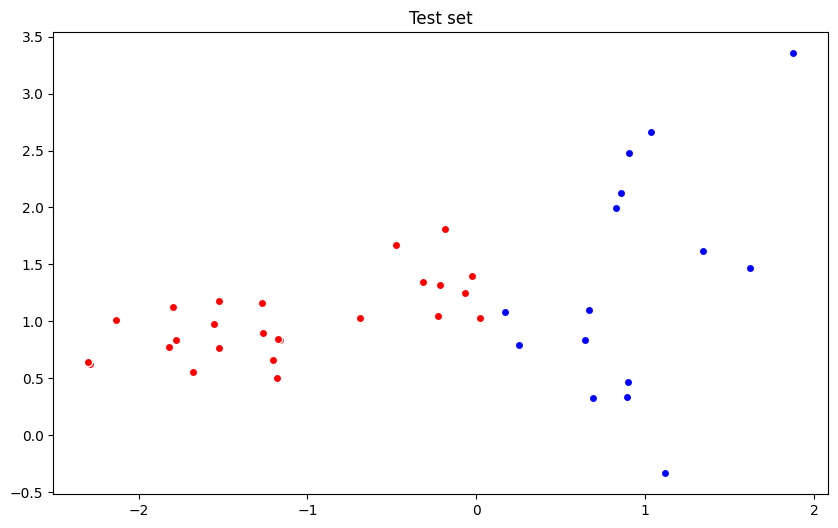

In [3]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
y_predicted = classifier.predict(X_test)

cls0 = [i for i in range(len(y_predicted)) if y_predicted[i] == 0]
cls1 = [i for i in range(len(y_predicted)) if y_predicted[i] == 1]
# cls0 = y_predicted[y_predicted == 0]
# cls1 = y_predicted[y_predicted == 1]

plt.figure(figsize=(10, 6))
plt.title("Test set")
plt.scatter(X_test[cls0].T[0], X_test[cls0].T[1], c="r", ec="w")
plt.scatter(X_test[cls1].T[0], X_test[cls1].T[1], c="b", ec="w")
plt.show()

A questo punto prendiamo a caso uno dei punti classificati, di seguito
rappresentato con una X, che sarà il nostro punto di riferimento per tutto ciò
che andremo a fare.


point: (0.17047, 1.08044)
class: 1


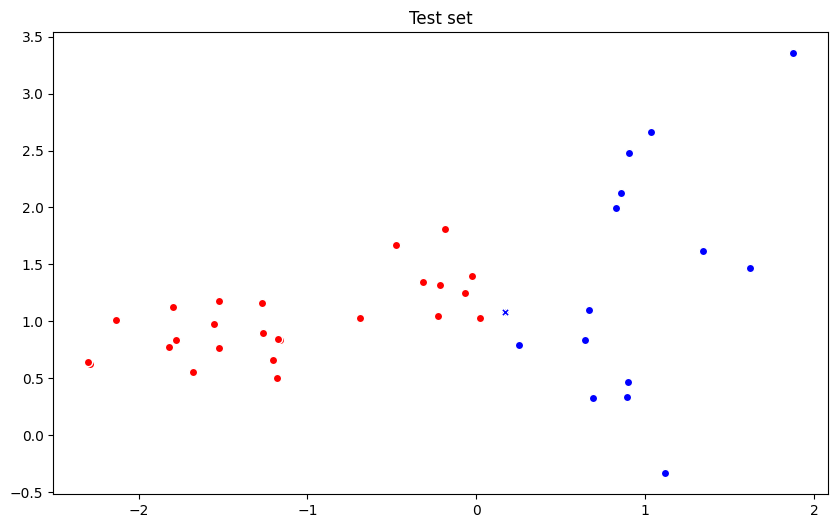

In [4]:
plt.figure(figsize=(10, 6))
plt.title("Test set")
plt.scatter(X_test[cls0].T[0], X_test[cls0].T[1], c="r", ec="w")
plt.scatter(X_test[cls1].T[0], X_test[cls1].T[1], c="b", ec="w")

j = 7
point = X_test[j]
print(f"point: ({point[0]:.5f}, {point[1]:.5f})")
point_class = y_predicted[j]
print(f"class: {point_class}")

c = "r" if point_class == 0 else "b"
plt.scatter(point[0], point[1], c=c, ec="w", marker="X")
plt.show()

## Algoritmo genetico

L'algoritmo genetico prevede di analizzare ogni singolo punto un numero di
volte pari al numero delle classi possibili (nel nostro caso solo due). Andremo
a definire due approcci volti a risolvere due problemi differenti:

1. Spiegare perché un determinato punto è stato classificato in un certo modo.
2. Capire come modificare le feature di quel punto il meno possibile per
   riuscire a classificarlo in tutte le altre possibili classi.

Come forma del cromosoma abbiamo semplicemente il vettore delle feature di
ciascun individuo.

### Generazione della popolazione iniziale

Come in ogni algoritmo genetico c'è bisogno di andare a generare una
popolazione iniziale. Nel nostro caso abbiamo bisogno che la popolazione
iniziale sia generata in modo che i nuovi individui siano simili a quello di
riferimento.

Per riuscire a generare una popolazione con queste caratteristiche possiamo
sfruttare la deviazione standard di ogni feature per generare un offset
coerente con il dataset che stiamo considerando su ogni asse.


In [5]:
sigma = X_test.std(axis=0)
sigma

array([1.17144131, 0.6751292 ])

I metodi utilizzabili sono principalmente tre:

- **Copia**: l'intera popolazione sintetica è composta da copie del punto di
  riferimento.
- **Uniforme**: si ottiene una popolazione sintetica equamente distribuita su
  ogni asse sfruttando un parametro $\alpha \in [0, 1]$ per regolare l'ampiezza
  dell'intervallo di valori. Intervallo definito in funzione della deviazione
  standard di ognuna delle feature. Avremo quindi che per ogni feature, lo
  spazio entro cui vengono generate le feature dei punti sintetici è il
  seguente
  $$[x_i - \sigma_i \cdot \alpha, \; x_ i + \sigma_i \cdot \alpha]$$
  dove $x_i$ è il valore dell'$i$-esima feature per il punto $x$ e $\sigma_i$ è
  la deviazione standard dell'$i$-esima feature rispetto a tutta la popolazione.
- **Normale**: in modo simile possiamo usare una distribuzione normale centrata
  nel valore della feature e usare sempre una frazione della deviazione
  standard piccola a piacere. Avremo quindi una distribuzione del tipo:
  $$N(x_i, \; \sigma_i \cdot \alpha)$$
  in cui $x_i$ è il valore dell'$i$-esima feature e $\sigma_i$ la sua
  deviazione standard.

Una distribuzione normale dovrebbe avere il vantaggio di riuscire a generare
i punti tenendo di conto della dispersione che ogni feature ha sul proprio asse.
In questo modo si riesce a produrre una nuvola di punti con una forma simile
a quella del dataset iniziale.

Una distribuzione uniforme riempe invece uno spazio arbitrariamente grande e
ben definito intorno al punto di riferimento. Potrebbe però non rispecchiare
la distribuzione dei punti del dataset di riferimento.


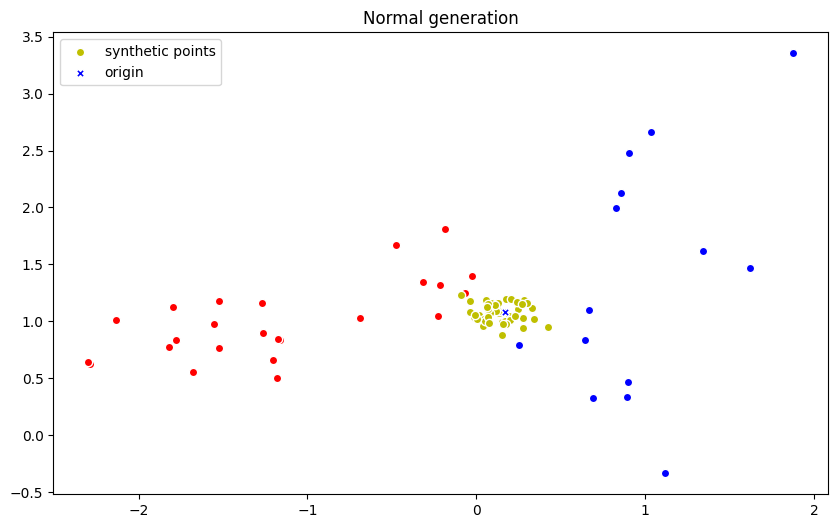

In [6]:
from numpy import random
from ppga import base


def generate_copy(point) -> np.ndarray:
    return point.copy()


def generate_uniform(low, high) -> np.ndarray:
    return random.uniform(low, high, size=point.shape)


def generate_normal(mu, sigma) -> np.ndarray:
    return random.normal(mu, sigma, size=point.shape)


toolbox = base.ToolBox()

# toolbox.set_generation(generate_copy, point=point)

# low = point - sigma * alpha
# high = point + sigma * alpha
# toolbox.set_generation(generate_uniform, low=low, high=high, alpha=0.1)

toolbox.set_generation(generate_normal, mu=point, sigma=sigma * 0.1)

# generazione di una popolazione composta da 50 individui
population = toolbox.generate(50)
synth_points = np.array([i.chromosome for i in population])

plt.figure(figsize=(10, 6))
plt.title("Normal generation")
plt.scatter(X_test[cls0].T[0], X_test[cls0].T[1], c="r", ec="w")
plt.scatter(X_test[cls1].T[0], X_test[cls1].T[1], c="b", ec="w")

plt.scatter(
    synth_points.T[0], synth_points.T[1], c="y", ec="w", label="synthetic points"
)

c = "r" if point_class == 0 else "b"
plt.scatter(point[0], point[1], c=c, ec="w", marker="X", label="origin")

plt.legend()
plt.show()

### Crossover

Gli operatori di crossover da testare sono principalmente due:

- **One point** o **Two Points**: operatori standard per il crossover, in
  questo, avendo solo due feature, sarebbe inutile applicare un crossover a
  due o più punti.
- **Media delle feature**: ogni figlio ha una certa probabilità di
  ereditare l'$i$-esima feature così com'è dal padre o dalla madre. In
  alternativa l'$i$-esima feature del figlio sarà la media tra la feature
  $i$-esima del padre e la feature $i$-esima della madre.

Per i test andremo ad usare un semplice _one point crossover_ dato che abbiamo
solo due feature.


In [7]:
from ppga import tools


toolbox.set_crossover(tools.cx_one_point)
o1, o2 = toolbox.crossover(population[0], population[1])
print(f"father: {population[0].chromosome}")
print(f"mother: {population[1].chromosome}")
print(f"offspring 1: {o1.chromosome}")
print(f"offspring 2: {o2.chromosome}")

father: [0.27451044 1.0293168 ]
mother: [0.24330519 1.10942693]
offspring 1: [0.27451044 1.10942693]
offspring 2: [0.24330519 1.0293168 ]


### Mutazione

L'operatore di mutazione andrà a modificare ogni feature di un termine
stocastico con una certa probabilità. Tale termine viene generato casualmente
tramite una distribuzione gaussiana. Ciò che potrebbe essere interessante è
variare il centro della distribuzione:

- Possiamo infatti centrare la gaussiana nel punto stesso in modo da generare
  un valore casuale con maggiore probabilità vicino al punto. In questo caso
  la distribuzione sarebbe la seguente:

  $$N(x_i, \; \alpha \cdot \sigma_i)$$

  centrata nel valore della feature $i$-esima ($x_i$) e con deviazione standard
  una frazione ($\alpha$) della deviazione standard di quella feature, calcolata
  sull'intera popolazione ($\sigma_i$).

  L'approccio è praticamente identico a quello usato per la generazione della
  popolazione sintetica tramite una distribuzione gaussiana.

- Un'altra possibilità è centrare la distribuzione nella media globale del
  dataset, ottenendo quindi

  $$N(\mu_i, \; \sigma_i)$$

  dove $\mu_i$ è la media della feature $i$-esima calcolata sull'intero dataset.

- L'ultima opzione vuole essere una via di mezzo tra le due. Si cerca infatti
  di far avvicinare i punti sintetici alla media della popolazione ma in modo
  graduale. Nella pratica si genera un valore casuale secondo la distribuzione

  $$N(\mu_i, \; \sigma_i)$$

  e si fa avvicinare la feature $i$-esima a tale valore di una frazione
  $\alpha$ della distanza che c'è tra i due. In questo modo si dovrebbe
  ottenere un avvicinamento graduale verso la media del dataset. Il nuovo
  valore della feature sarà dato dalla seguente formula:

  $$x_i = x_i + r_i * \alpha$$

  dove $r_i$ è un valore generato casualmente secondo la distribuzione
  descritta sopra.

Per le varie simulazioni verrà impiegato il secondo metodo prendendo media e
deviazione standard globali senza alcuna modifica.


In [8]:
def mut_normal_pt(individual, sigma, indpb: float = 0.5):
    for i, f in enumerate(individual):
        if random.random() <= indpb:
            individual[i] = random.normal(loc=f, scale=sigma[i])

    return individual


def mut_normal(individual, mu, sigma, indpb: float = 0.5):
    for i in range(len(individual)):
        if random.random() <= indpb:
            individual[i] = random.normal(loc=mu[i], scale=sigma[i])

    return individual


def mut_normal2(individual, mu, sigma, alpha: float = 0.1, indpb: float = 0.5):
    for i in range(len(individual)):
        if random.random() <= indpb:
            individual[i] += random.normal(loc=mu[i], scale=sigma[i]) * alpha

    return individual


mu = X_test.mean(axis=0)
toolbox.set_mutation(mut_normal, mu, sigma, 0.8)

print(f"before: {o1.chromosome}")
o1 = toolbox.mutate(o1)
print(f"after: {o1.chromosome}")

before: [0.27451044 1.10942693]
after: [-0.68639464  0.68050876]


### Funzione di valutazione

Uno dei punti cruciali dell'algoritmo è ovviamente la funzione di valutazione.
Nel caso in cui si vogliano studiare solo due casistiche a prescindere dal
numero di classi, sarebbe necessario scrivere due funzioni di valutazione
differenti:

- Una che valuta meglio i punti sintetici classificati come quello d'origine.
- L'altra che valuta bene i punti sintetici classificati diversamente.

L'approccio sfruttato in questo caso è leggermente diverso e ci permette di
scrivere una sola funzione di valutazione. La funzione in questione prende in
input la classe target in cui vogliamo che i punti sintetici siano classificati.

Per coprire il primo caso basterà fornire come classe target la classe del punto
di riferimento. Sarà poi necessario fornire come target tutte le altre classi
per riuscire a fare un'analisi più completa.

Questo approccio ha lo svantaggio di dover eseguire $n$ volte l'algoritmo
genetico per ogni punto, dove $n$ è il numero di classi possibili. Ha però il
vantaggio di riuscire a fornire dei risultati più precisi per ogni classe
presente. Dato che nel nostro caso abbiamo solo due classi, i due approcci sono
equivalenti.

Il valore di fitness in sé dipende molto dalla **distanza euclidea** tra i
due punti. Sebbene l'obbiettivo sia minimizzare la distanza tra i punti
sintetici e il punto d'origine, non vogliamo che questi si avvicinino troppo
poiché non si otterrebbe alcuna informazione interessante. Vogliamo infatti
minimizzare la distanza ma mantenere un certo grado di separazione tra i punti
sintetici e quello di riferimento. Per mitigare il problema sarà sufficiente
calcolare un certo valore $\epsilon$ sotto il quale la distanza non può
scendere.

Si fa inoltre uso di un parametro $\alpha$, il quale offre la possibilità di
bilanciare la corretta o errata classificazione del punto sintetico rispetto
alla classe target.


In [ ]:
from numpy import linalg
import warnings

warnings.filterwarnings("ignore")


def evaluate(
    chromosome, point, target, classifier, epsilon: float = 0.0, alpha: float = 0.0
):
    assert alpha >= 0.0 and alpha <= 1.0

    # classification
    synth_class = classifier.predict(chromosome.reshape(1, -1))

    # compute euclidean distance
    distance = linalg.norm(chromosome - point, ord=2)

    # compute classification penalty
    right_target = 1.0 - alpha if target == synth_class[0] else alpha

    # check the epsilon distance
    if distance <= epsilon:
        return (np.inf,)

    return (distance / right_target,)


toolbox.set_weights((-1.0,))
epsilon = 0.0
# epsilon = linalg.norm(sigma * 0.1, ord=2)
toolbox.set_evaluation(evaluate, point, point_class, classifier, epsilon, 0.0)
population = list(map(toolbox.evaluate, population))

Abbiamo quindi una funzione che, oltre a parametri come il punto di
riferimento, la classe target e il classificatore, ha bisogno di 2 parametri
fondamentali:

- `epsilon`: valore minimo di distanza dal punto d'origine.
- `alpha`: coefficiente compreso tra 0 e 1.

La scelta di entrambi i valori rimane a carico del programmatore, in quanto
forniscono la base per analisi di tipo differente. Possiamo vedere il valore
di $\alpha$ come la penalità che vogliamo dare alla "corretta" classificazione
e, di conseguenza, la penalità che vogliamo dare alla classificazione "errata".
Abbiamo infatti che il valore di distanza effettivo calcolato è dato dalla
seguente funzione:

$$
    f(x, x_0) = \begin{cases}
       \frac{\| x - x_0 \|_2}{1 - \alpha} & \text{se } C_x = C_t \\
       \frac{\| x - x_0 \|_2}{\alpha} & \text{altrimenti}
    \end{cases}
$$

Dove $x$ e $C_x$ sono rispettivamente il punto sintetico e la sua classe, $x_0$
è il punto d'origine e $C_t$ la classe target. Ovviamente vogliamo mantenere un
valore di $\alpha$ minore o uguale di $0.5$ per ottenere l'effetto desiderato.
Il valore di default per $\alpha$ è tuttavia $0$, così da far diventare la
distanza di tutti i punti non classificati nella classe target $+\infty$. Più si
alza il valore di $\alpha$ e più si appiana la differenza di valutazione tra
punti con classi diverse.

Il valore $\epsilon$, che di default è a $0$, serve a scartare tutti i punti
che si avvicinano troppo a quello di riferimento. Quello che fa la funzione è
semplicemente aggiungere $+\infty$ alla distanza del punto qual'ora questo
avesse una distanza dal punto di riferimento inferiore a $\epsilon$.


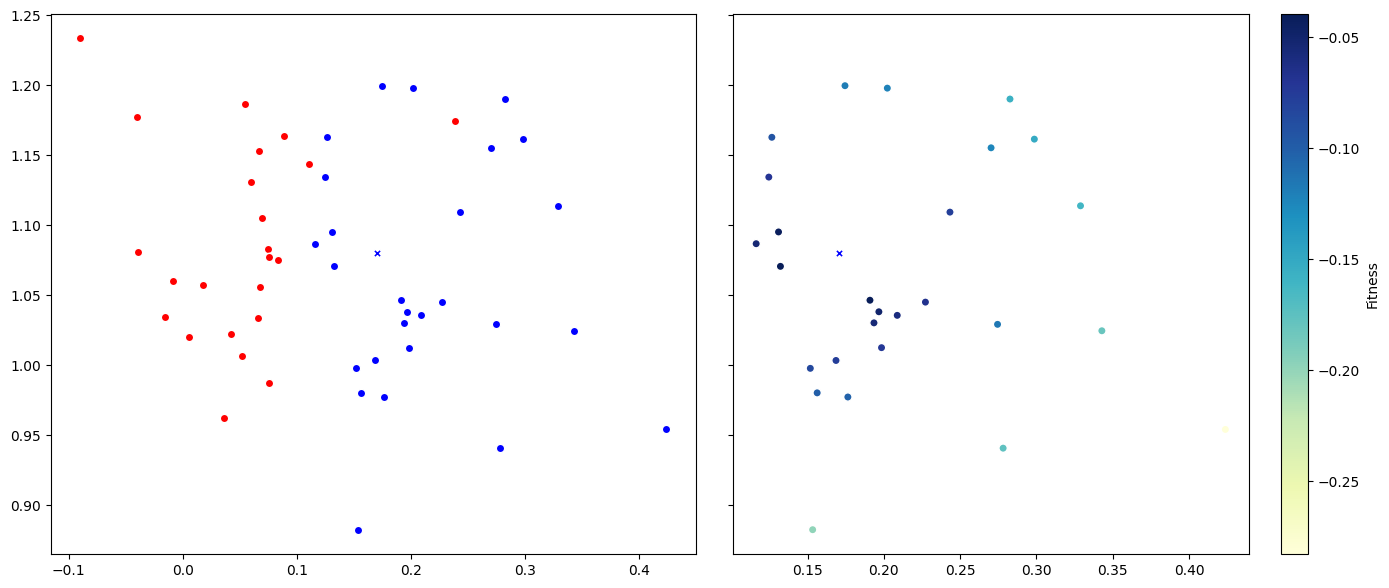

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))
plt.tight_layout()

synth_classes = [classifier.predict(sp.reshape(1, -1)) for sp in synth_points]

scls0 = [i for i in range(len(synth_classes)) if synth_classes[i] == 0]
scls1 = [i for i in range(len(synth_classes)) if synth_classes[i] == 1]

# classification plot
ax1.scatter(synth_points[scls0].T[0], synth_points[scls0].T[1], c="r", ec="w")
ax1.scatter(synth_points[scls1].T[0], synth_points[scls1].T[1], c="b", ec="w")
ax1.scatter(point[0], point[1], c=c, ec="w", marker="X")

# fitness plot
fitness_values = [i.fitness for i in population]
sc = ax2.scatter(
    synth_points.T[0],
    synth_points.T[1],
    c=fitness_values,
    ec="w",
    cmap=plt.get_cmap("YlGnBu"),
)
fig.colorbar(sc, ax=ax2, label="Fitness")
ax2.scatter(point[0], point[1], c=c, ec="w", marker="X")

plt.show()

Come si può notare i punti classificati diversamente dal punto d'origine non
compaiono neanche dato che abbiamo impostato $\alpha$ a $0$. Possiamo invece
notare come i punti rimasti abbiamo una fitness tanto più alto quanto più sono
vicini al punto d'origine. In questo caso abbiamo $\epsilon = 0$ ma, nel caso
avessimo avuto un valore più alto, anche alcuni dei punti classificati
correttamente sarebbero stati scartati.

Quando si vuole studiare come fare a cambiare classe ci basta cambiare classe
target e rieseguire l'algoritmo.


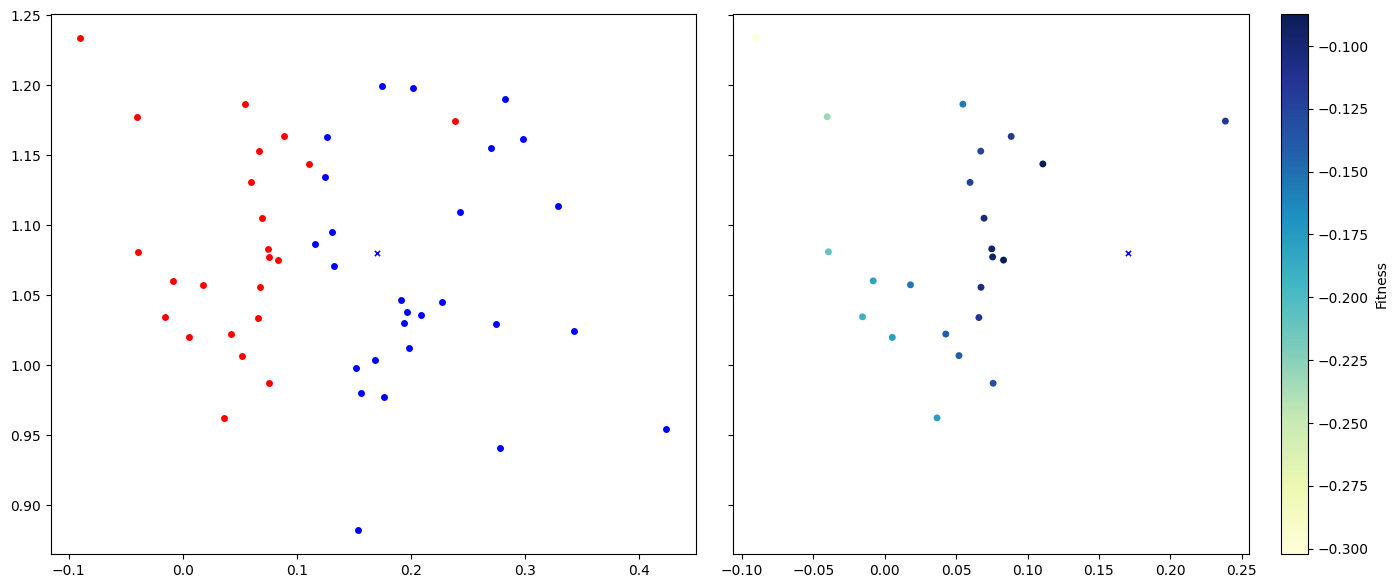

In [11]:
toolbox.set_weights((-1.0,))
target = (point_class + 1) % 2
toolbox.set_evaluation(evaluate, point, target, classifier, epsilon, 0.0)
population = list(map(toolbox.evaluate, population))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))
plt.tight_layout()

synth_classes = [classifier.predict(sp.reshape(1, -1)) for sp in synth_points]

scls0 = [i for i in range(len(synth_classes)) if synth_classes[i] == 0]
scls1 = [i for i in range(len(synth_classes)) if synth_classes[i] == 1]

# classification plot
ax1.scatter(synth_points[scls0].T[0], synth_points[scls0].T[1], c="r", ec="w")
ax1.scatter(synth_points[scls1].T[0], synth_points[scls1].T[1], c="b", ec="w")
ax1.scatter(point[0], point[1], c=c, ec="w", marker="X")

# fitness plot
fitness_values = [i.fitness for i in population]
sc = ax2.scatter(
    synth_points.T[0],
    synth_points.T[1],
    c=fitness_values,
    ec="w",
    cmap=plt.get_cmap("YlGnBu"),
)
fig.colorbar(sc, ax=ax2, label="Fitness")
ax2.scatter(point[0], point[1], c=c, ec="w", marker="X")

plt.show()

### Simulazione caso 1

Entrambe le simulazioni verrano eseguite sullo stesso punto usato per gli
esempi. Per il momento ci occuperemo di effettuare una simulazione per la
prima casistica dell'algoritmo in cui cerchiamo di produrre individui simili
a quello iniziale e classificati allo stesso modo.

Il metodo di generazione della popolazione iniziale è quello dato dal metodo
`generate_copy` che quindi genera la popolazione iniziale clonando $n$ volte
il punto di riferimento.

L'algoritmo usa una politica cosiddetta "elitista" regolata dal parametro
`keep`, il quale indica, in percentuale, quanta della vecchia generazione
vogliamo tenere. Nel nostro caso portiamo nella nuova generazione il 10%
dei migliori individui della vecchia generazione.


In [12]:
def plot_results(hof_synth_points, pop_synth_points):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))
    plt.tight_layout()

    ax1.set_title("Hall of fame")
    ax1.scatter(X_test[cls0].T[0], X_test[cls0].T[1], c="r", ec="w")
    ax1.scatter(X_test[cls1].T[0], X_test[cls1].T[1], c="b", ec="w")

    ax1.scatter(
        hof_synth_points.T[0], hof_synth_points.T[1], c="y", ec="w", label="synthetic"
    )

    c = "r" if point_class == 0 else "b"
    ax1.scatter(point[0], point[1], c=c, ec="w", marker="X", label="origin")
    ax1.legend()

    ax2.set_title("Last generation")
    ax2.scatter(X_test[cls0].T[0], X_test[cls0].T[1], c="r", ec="w")
    ax2.scatter(X_test[cls1].T[0], X_test[cls1].T[1], c="b", ec="w")

    ax2.scatter(
        pop_synth_points.T[0],
        pop_synth_points.T[1],
        c="y",
        ec="w",
        label="synthetic points",
    )

    c = "r" if point_class == 0 else "b"
    ax2.scatter(point[0], point[1], c=c, ec="w", marker="X", label="origin")
    ax2.legend()

    plt.show()

Di seguito la simulazione vera e propria tramite un versione parallela
dell'algoritmo genetico.


100%|#########################################| 100/100 [00:17<00:00,  5.56it/s]


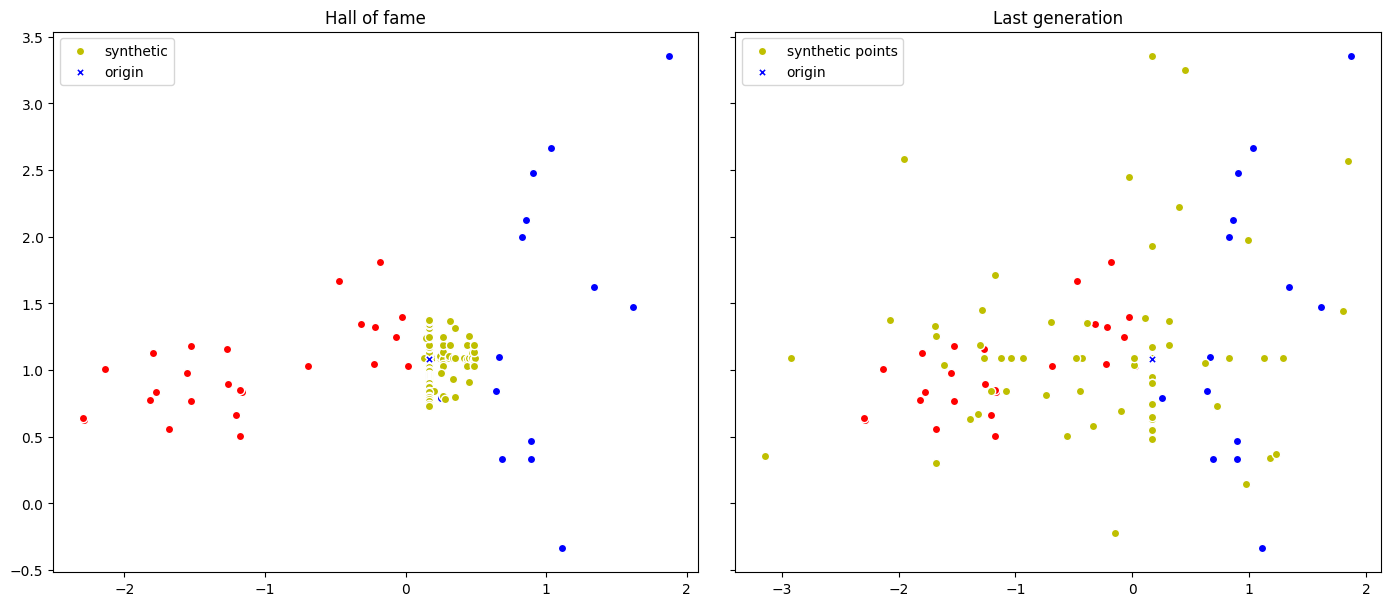

In [13]:
from ppga import algorithms

toolbox.set_generation(generate_copy, point)
toolbox.set_evaluation(evaluate, point, point_class, classifier, epsilon, 0.0)
toolbox.set_selection(tools.sel_tournament, tournsize=3)

hof = base.HallOfFame(100)
population, stats = algorithms.pelitist(
    toolbox=toolbox,
    population_size=500,
    keep=0.1,
    cxpb=0.8,
    mutpb=0.2,
    max_generations=100,
    hall_of_fame=hof,
)

hof_synth_points = np.array([i.chromosome for i in hof])
pop_synth_points = np.array([i.chromosome for i in population])

plot_results(hof_synth_points, pop_synth_points)

#### Analisi

Svolgiamo dunque una semplice analisi andando a prendere dalla _Hall of Fame_
e dalla popolazione finale, tutti i punti e dividiamoli per classe. Una volta
divisi possiamo vedere quanti di questi sono classificati come il punto di
riferimento rispetto al totale dei punti. Otteniamo così una sorta di indice
di precisione dell'algoritmo genetico.

Tale indice andrebbe però interpretato più approfonditamente, tenendo di conto
anche di altri parametri come ad esempio il valore dei parametri $\epsilon$ e
$\alpha$. Tali parametri potrebbero infatti portare ad un naturale calo della
precisione:

- Un $\epsilon$ alto potrebbe allontanare troppo i punti sintetici, cosa che in
  in questa casistica vogliamo evitare.
- Un $\alpha$ troppo alto aumenterebbe la tolleranza sui punti classificati
  diversamente dalla classe target.

Nel nostro caso usiamo valori estremi di entrambi per avere condizioni più
stringenti possibile. Diventa quindi normale aspettarsi un indice di precisione
con valori alti soprattutto in prossimità del boundary di classificazione.


In [14]:
hof_cls = [classifier.predict(i.reshape(1, -1))[0] for i in hof_synth_points]
pop_cls = [classifier.predict(i.reshape(1, -1))[0] for i in pop_synth_points]

hof_target_class = len([i for i in hof_cls if i == point_class])
pop_target_class = len([i for i in pop_cls if i == point_class])

print(f"Hall of fame right class points: {hof_target_class}")
print(f"Hall of fame wrong class points: {len(hof) - hof_target_class}")
print(f"Hall of fame accuracy: {hof_target_class / len(hof) * 100.0:.2f}%")

print(f"Last generation right class points: {pop_target_class}")
print(f"Last generation wrong class points: {len(population) - pop_target_class}")
print(f"Last generation accuracy: {pop_target_class / len(population) * 100.0:.2f}%")

Hall of fame right class points: 100
Hall of fame wrong class points: 0
Hall of fame accuracy: 100.00%
Last generation right class points: 424
Last generation wrong class points: 38
Last generation accuracy: 91.77%


### Simulazione caso 2

Stavolta la simulazione verrà eseguita cercando di far cambiare classe ai punti
sintetici.


100%|#########################################| 100/100 [00:17<00:00,  5.58it/s]


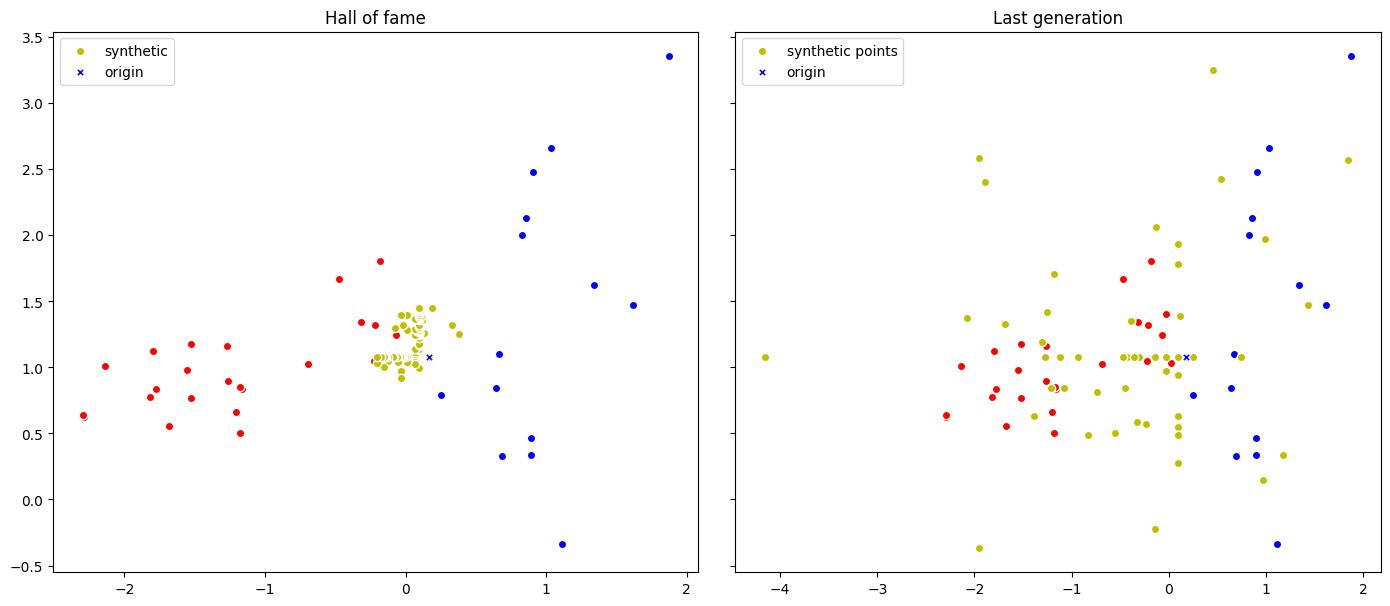

In [15]:
target = (point_class + 1) % 2
toolbox.set_evaluation(evaluate, point, target, classifier, epsilon, 0.0)
toolbox.set_selection(tools.sel_tournament, tournsize=3)

hof = base.HallOfFame(100)
population, stats = algorithms.pelitist(
    toolbox=toolbox,
    population_size=500,
    keep=0.1,
    cxpb=0.8,
    mutpb=0.2,
    max_generations=100,
    hall_of_fame=hof,
)

hof_synth_points = np.array([i.chromosome for i in hof])
pop_synth_points = np.array([i.chromosome for i in population])

plot_results(hof_synth_points, pop_synth_points)

#### Analisi

L'analisi è analoga a quella precedente. Ovviamente l'indice di precisione
ha un significato simbolico per quanto riguarda l'explainability. Ci dice
solo quanti punti sono stati classificati nella classe target in percentuale.


In [16]:
hof_cls = [classifier.predict(i.reshape(1, -1))[0] for i in hof_synth_points]
pop_cls = [classifier.predict(i.reshape(1, -1))[0] for i in pop_synth_points]

hof_target_class = len([i for i in hof_cls if i == target])
pop_target_class = len([i for i in pop_cls if i == target])

print(f"Hall of fame right class points: {hof_target_class}")
print(f"Hall of fame wrong class points: {len(hof) - hof_target_class}")
print(f"Hall of fame accuracy: {hof_target_class / len(hof) * 100.0:.2f}%")

print(f"Last generation right class points: {pop_target_class}")
print(f"Last generation wrong class points: {len(population) - pop_target_class}")
print(f"Last generation accuracy: {pop_target_class / len(population) * 100.0:.2f}%")

Hall of fame right class points: 100
Hall of fame wrong class points: 0
Hall of fame accuracy: 100.00%
Last generation right class points: 427
Last generation wrong class points: 26
Last generation accuracy: 94.26%


La Hall of Fame che ho implementato dovrebbe garantire diversità genetica
massima. Non in termini di differenza nei valori delle feature ma in termini
di duplicati. Nella Hall of Fame non possono infatti esserci individui
duplicati ed ha una semantica simile a quella di un _set_ ordinato per
fitness decrescente.

### Simulazione con punto estremo

Ripetiamo le due simulazioni su un punto agli estremi del dataset.


point: (-2.13374, 1.00816)
class: 0


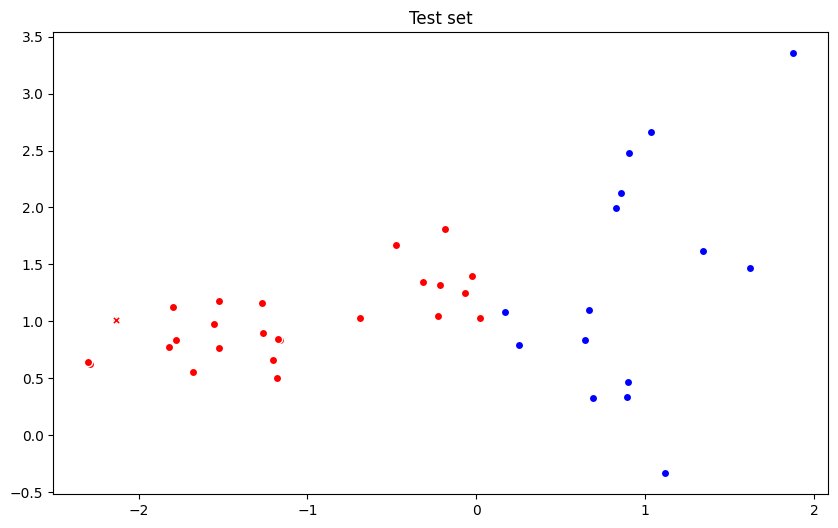

In [17]:
point = X_test[6]
print(f"point: ({point[0]:.5f}, {point[1]:.5f})")
point_class = y_predicted[6]
print(f"class: {point_class}")

c = "r" if point_class == 0 else "b"

plt.figure(figsize=(10, 6))
plt.title("Test set")
plt.scatter(X_test[cls0].T[0], X_test[cls0].T[1], c="r", ec="w")
plt.scatter(X_test[cls1].T[0], X_test[cls1].T[1], c="b", ec="w")

plt.scatter(point[0], point[1], c=c, ec="w", marker="X")
plt.show()

#### Caso 1

Iniziamo quindi cercando di far rimanere i punti della stessa classe
del punto di partenza.


In [18]:
toolbox.set_evaluation(evaluate, point, point_class, classifier, epsilon, 0.0)
toolbox.set_selection(tools.sel_tournament, tournsize=3)

hof = base.HallOfFame(100)
population, stats = algorithms.pelitist(
    toolbox=toolbox,
    population_size=500,
    keep=0.1,
    cxpb=0.8,
    mutpb=0.2,
    max_generations=100,
    hall_of_fame=hof,
)

100%|#########################################| 100/100 [00:18<00:00,  5.43it/s]


Di seguito il grafico del risultato finale.


Hall of fame right class points: 100
Hall of fame wrong class points: 0
Hall of fame accuracy: 100.00%
Last generation right class points: 428
Last generation wrong class points: 16
Last generation accuracy: 96.40%


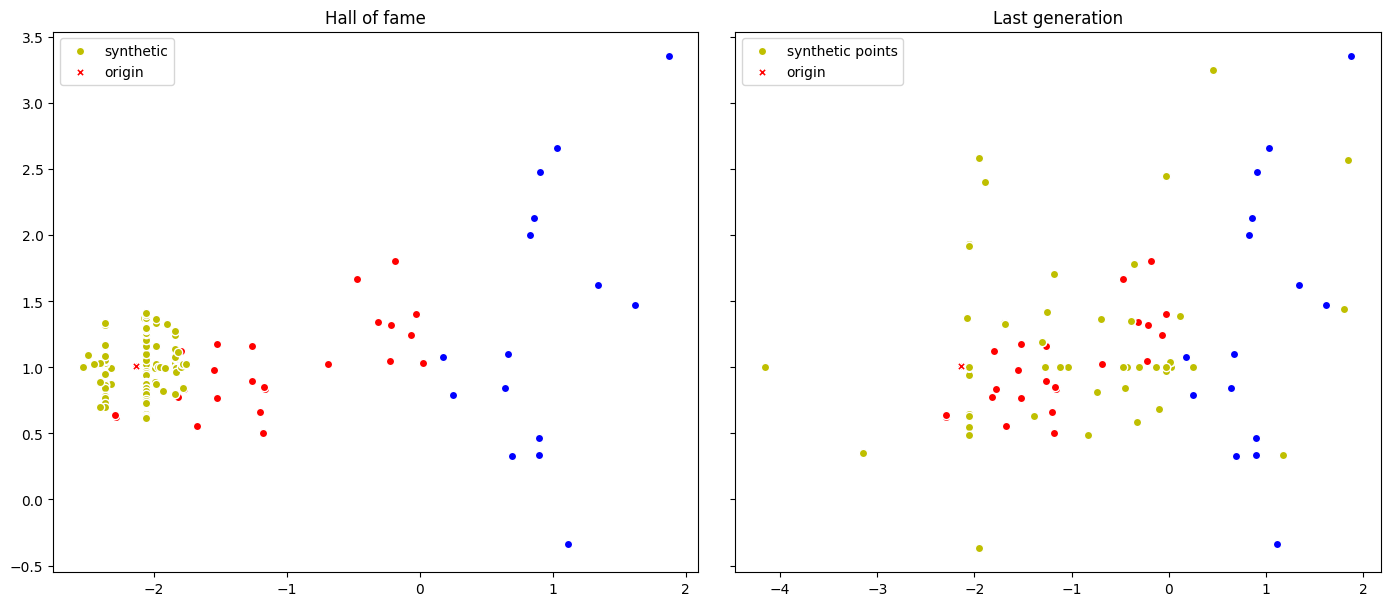

In [19]:
hof_synth_points = np.array([i.chromosome for i in hof])
pop_synth_points = np.array([i.chromosome for i in population])

hof_cls = [classifier.predict(i.reshape(1, -1))[0] for i in hof_synth_points]
pop_cls = [classifier.predict(i.reshape(1, -1))[0] for i in pop_synth_points]

hof_target_class = len([i for i in hof_cls if i == point_class])
pop_target_class = len([i for i in pop_cls if i == point_class])

print(f"Hall of fame right class points: {hof_target_class}")
print(f"Hall of fame wrong class points: {len(hof) - hof_target_class}")
print(f"Hall of fame accuracy: {hof_target_class / len(hof) * 100.0:.2f}%")

print(f"Last generation right class points: {pop_target_class}")
print(f"Last generation wrong class points: {len(population) - pop_target_class}")
print(f"Last generation accuracy: {pop_target_class / len(population) * 100.0:.2f}%")

plot_results(hof_synth_points, pop_synth_points)

##### Analisi

Come possiamo vedere, otteniamo dei buoni risultati anche quando il punto
è lontano dal boundary di classificazione. In entrambi i casi i punti
sintetici sono abbastanza lontani dal punto d'origine, poiché utilizziamo
un operatore di mutazione basato sulla generazione gaussiana di numeri
casuali, centrando la distribuzione nella media del valore delle feature
dell'intero dataset.

In questo caso la zona vicino alla media delle feature è anche la stessa
in cui troviamo il boundary di classificazione. Avere questo tipo di
mutazione ci risulta quindi molto conveniente.

Nel primo caso, nonostante i punti si siano allontanati molto dal punto
d'origine, sono riusciti a non cambiare mai classe. Questo ci suggerisce che
il modello abbia effettuato una classificazione corretta.

#### Caso 2

Cerchiamo ora di far cambiare classe ai punti sintetici.


In [20]:
target = (point_class + 1) % 2
toolbox.set_evaluation(evaluate, point, target, classifier, epsilon, 0.0)
toolbox.set_selection(tools.sel_tournament, tournsize=3)

hof = base.HallOfFame(100)
population, stats = algorithms.pelitist(
    toolbox=toolbox,
    population_size=500,
    keep=0.1,
    cxpb=0.8,
    mutpb=0.2,
    max_generations=100,
    hall_of_fame=hof,
)

100%|#########################################| 100/100 [00:18<00:00,  5.34it/s]


Di seguito i risultati.


Hall of fame right class points: 100
Hall of fame wrong class points: 0
Hall of fame accuracy: 100.00%
Last generation right class points: 398
Last generation wrong class points: 49
Last generation accuracy: 89.04%


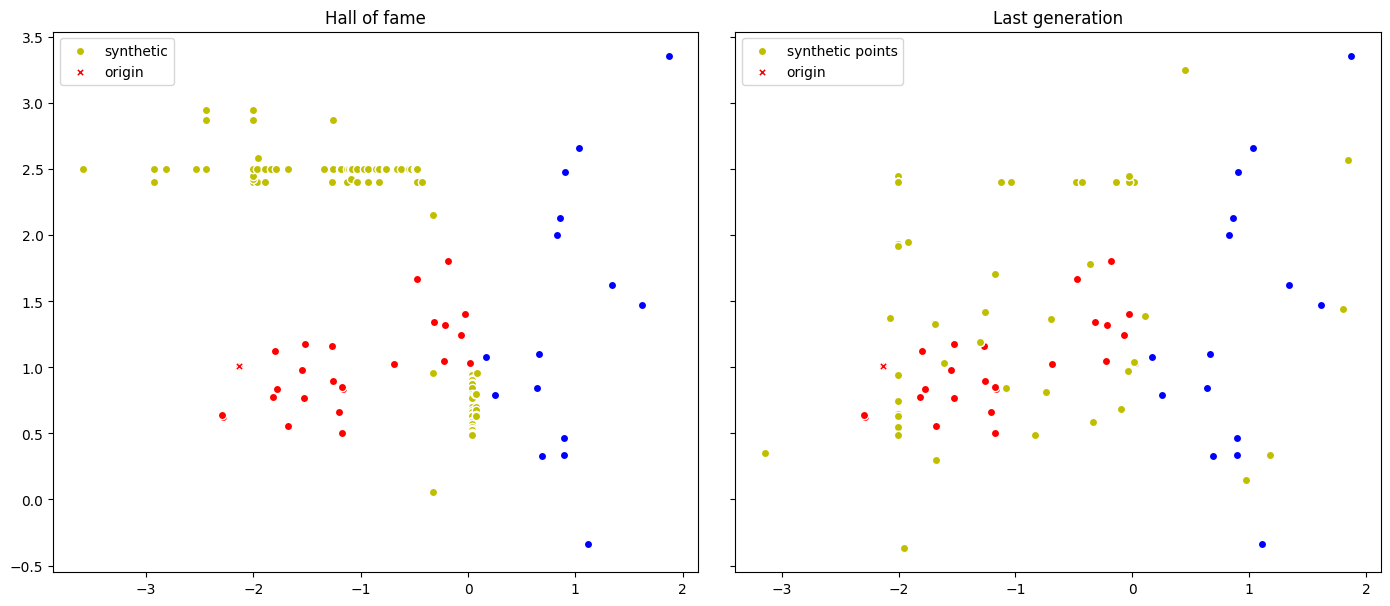

In [21]:
hof_synth_points = np.array([i.chromosome for i in hof])
pop_synth_points = np.array([i.chromosome for i in population])

hof_cls = [classifier.predict(i.reshape(1, -1))[0] for i in hof_synth_points]
pop_cls = [classifier.predict(i.reshape(1, -1))[0] for i in pop_synth_points]

hof_target_class = len([i for i in hof_cls if i == target])
pop_target_class = len([i for i in pop_cls if i == target])

print(f"Hall of fame right class points: {hof_target_class}")
print(f"Hall of fame wrong class points: {len(hof) - hof_target_class}")
print(f"Hall of fame accuracy: {hof_target_class / len(hof) * 100.0:.2f}%")

print(f"Last generation right class points: {pop_target_class}")
print(f"Last generation wrong class points: {len(population) - pop_target_class}")
print(f"Last generation accuracy: {pop_target_class / len(population) * 100.0:.2f}%")

plot_results(hof_synth_points, pop_synth_points)

##### Analisi

Nel secondo caso, nonostante la distanza, molti dei punti sono riusciti a
cambiare classe. In questo modo è possibile fare un'analisi su di essi per
capire come variare il valore delle feature per cambiare la classificazione.

Se la mutazione fosse invece stata centrata nel punto d'origine,
probabilmente non sarebbe mai avvenuto un cambio di classe.
Questo in generale non lascia spazio a successive analisi e l'unica cosa
che si può dedurre è che ci si trova troppo lontano dal boundary di
classificazione.

Si vede inoltre che i parametri della mutazione hanno permesso la scoperta di
boundary di classificazione visivamente non identificabili (almeno non in modo
facile). Sembra infatti esserci un boundary superiore che però non coinvolge
punti presenti nel dataset. Ovviamente prendendo una frazione della deviazione
standard, la mutazione tenderà a generare nuove coordinate dove c'è maggiore
densità di punti.
